In [1]:
%matplotlib inline
#
from LRGSG_package.LRGSG import *
move_to_rootf(print_tf=True)
plt.style.use('nb/nb_plotsheet.mplstyle')

#
subdatapath = os.path.join('plot', 'paper', 'suppinf/')
fullpath = os.path.join("data", subdatapath)

cwd: /home/opisthofulax/PhD/projects/complex-networks/LRG-Signed


In [10]:
side = 256
pflip = 0.25
geometry = 'squared'
cell = 'randZERR'
#
lattice = Lattice2D(#
    side1 = side,
    geo = geometry,
    pflip=pflip,
    sgpath=subdatapath, 
    with_positions=True
)
#
fliplist = lattice.neg_weights_dict[cell]['G']
lattice.flip_sel_edges(fliplist)
lattice.compute_k_eigvV()

lattice2 = Lattice2D(#
    side1 = 32,
    geo = geometry,
    pflip=pflip,
    pbc=False,
    sgpath=subdatapath, 
    with_positions=True
)
fliplist = lattice2.neg_weights_dict[cell]['G']
lattice2.flip_sel_edges(fliplist)
lattice2.compute_k_eigvV()

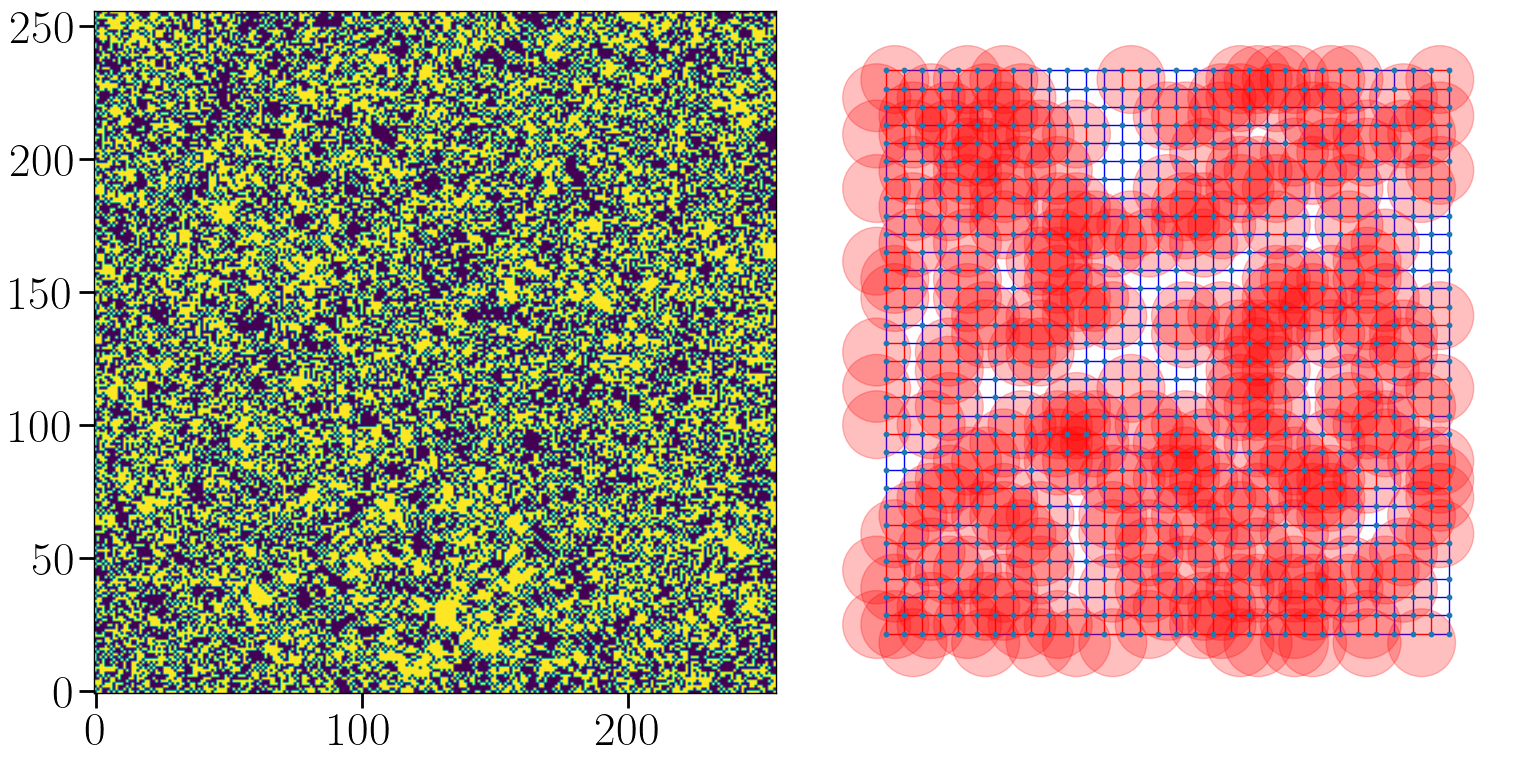

In [11]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(np.sign(lattice.eigV[0].reshape(lattice.syshape)))
nx.draw(lattice2.G, pos = lattice2.get_pos(), 
    edge_color=lattice2.get_edge_color(), ax=ax[1], node_size=10)
ax[1].set_aspect('equal')
if cell == 'rand':
    for i in lattice2.rEdgeFlip['G']:
        circle_center = (i[0][0]+.5, i[0][1])
        circle = plt.Circle(circle_center, lattice2.r_c, color='red', alpha=0.25)
        ax[1].add_patch(circle)
elif cell == 'randXERR':
    for circle_center in lattice2.neg_weights_dict.rNodeFlip['G']:
        circle = plt.Circle(circle_center, lattice2.r_c, color='red', alpha=0.25)
        ax[1].add_patch(circle)
elif cell == 'randZERR':
    for i in lattice2.neg_weights_dict.rNodeFlip['G']:
        circle_center = (i[0]-.5, i[1]-.5)
        circle = plt.Circle(circle_center, lattice2.r_c, color='red', alpha=0.25)
        ax[1].add_patch(circle)
fig.tight_layout()
fig.savefig(f"{fullpath}{geometry}_{side}_{pflip}_{cell}.pdf", 
    bbox_inches='tight', transparent=True)

